# Gradient Boosting Classifier
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

In [4]:
from sklearn import ensemble
import GPyOpt, numpy as np, seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run collect_and_name_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
from paramz import Model, Param

In [16]:
class ParamzGradientBoostingClassifier(Model):
    def __init__(self, X, y, learning_rate=1., name='ParamzGradientBoostingClassifier'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzGradientBoostingClassifier, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.learning_rate = Param('learning rate', learning_rate)
        self.link_parameter(self.learning_rate)
        self.sk = StratifiedKFold(train_labels, shuffle=True, n_folds=5)
        
    def parameters_changed(self):
        from sklearn.metrics import f1_score
    
        self._obj = 0.
        #svc = svm.LinearSVC(C=float(self.C.values), class_weight='balanced')
        svc = ensemble.GradientBoostingClassifier(learning_rate=float(self.learning_rate.values), 
                                                  n_estimators=50,
                                                  max_depth=3,
                                                  )
    
        for train_index, test_index in self.sk:
            svc = svc.fit(self.X[train_index], self.y[train_index])
            prediction = svc.predict(self.X[test_index])
            self._obj += f1_score(self.y[test_index], prediction)/float(self.sk.n_folds)
            
    def objective_function(self):
        import numpy as np
        #print self._obj,
        return -np.atleast_1d(self._obj)

In [17]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx    

train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']

In [18]:
def get_train_test_set(data, train_idx, test_idx):
    train_set = data.loc[:, train_idx].copy()
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx].copy()
    test_set[:] = normalizer.transform(test_set.T).T
    
    return train_set, test_set

In [19]:
def make_f(m):
    def f(X):
        ret = np.empty((X.shape[0],1))
        for i in range(X.shape[0]):
            ret[i] = m._objective(X[i])
        return ret
    return f

In [ ]:
train_errors = {}

for i in range(len(all_data)):
    data = all_data[i]
    print data.name
    train_set, test_set = get_train_test_set(data, train_idx, test_idx)
    
    m = ParamzGradientBoostingClassifier(train_set.T.values, train_labels.values)
    m_opt = GPyOpt.methods.BayesianOptimization(make_f(m), 
                                            bounds=[
                                                    (np.exp(-15),1.),
                                                    ], 
                                            model_optimize_restarts = 15,
                                            normalize=True,
                                            acquisition = 'EI',
                                            type_initial_design='latin')
    print
    m_opt.run_optimization(60, eps=1e-5)
    print
    train_errors[data.name] = [m_opt.fx_opt, m_opt.x_opt]

In [71]:
train_errors

{'all_genes': [array([-0.13080993]), array([ 0.175     ,  0.58333333])],
 'effector_genes': [array([-0.60505051]),
  array([  1.00000000e-100,   2.46976217e-003])],
 'mod_activities': [array([-0.72498488]), array([ 0.10917599,  0.        ])],
 'mod_genevalues': [array([-0.7556038]), array([ 0.3,  0. ])],
 'mod_nodevalues': [array([-0.66984054]), array([ 0.27467537,  0.01603844])],
 'signaling_genes': [array([-0.6665873]), array([ 0.06368757,  0.00151611])]}

In [77]:
results = pd.DataFrame(columns=['acc', 'C', 'gamma'], 
                       index=train_errors.keys(),
                       dtype=float)
acc, cg = zip(*train_errors.values())
results['acc'] = -np.concatenate(acc)
C,g = [[_c[i] for _c in cg] for i in range(2)]
results['C'] = C
results['gamma'] = g

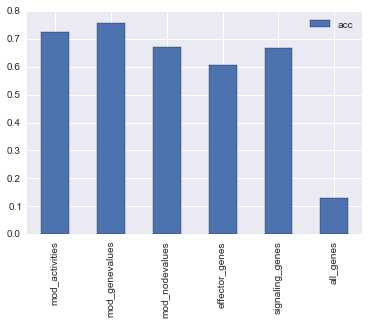

In [91]:
results.plot(kind='bar', y='acc')

In [92]:
best = results.acc.idxmax(0)
print best

mod_genevalues


## Work on best training data:

In [93]:
svc = svm.SVC(C=results.loc[best, 'C'], 
                      gamma=results.loc[best, 'gamma'], 
                      kernel='rbf', 
                      decision_function_shape='ovr', 
                      probability=True, 
                      class_weight='balanced')

In [94]:
train_set, test_set = get_train_test_set(rnaseq_mod_genevalues, train_idx, test_idx)
svc.fit(train_set.T.values, train_labels)

SVC(C=0.29999999999999999, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
prediction_probabilities = pd.DataFrame(svc.predict_proba(test_set.T.values), index=test_set.columns, columns=svc.classes_)

In [97]:
test_labels.value_counts()
test_labels_collected = test_labels.copy()
test_labels_collected[(test_labels_collected=='Effect_6')+(test_labels_collected=='Effect_7')] = 'Unknown'
#test_labels_collected = pd.get_dummies(test_labels_collected)

## Roc curve for each class:

In [109]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [110]:
rocs = {}
for c in prediction_probabilities.columns:
    rocs[c] = roc_curve(test_labels_collected==c, prediction_probabilities[c])

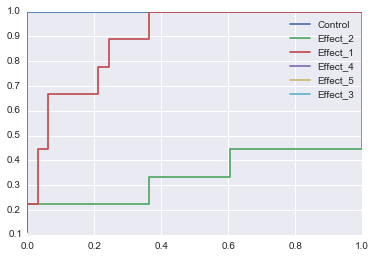

In [111]:
for name in rocs:
    plt.plot(rocs[name][0], rocs[name][1], label=name)
plt.legend()

## Try to use the predicted probabilities to find unknown classes:

In [163]:
def predict_classes(prediction_probabilities, threshold):
    import scipy
    #sort = np.argsort(prediction_probabilities, 1).values[:, ::-1]
    prediction = prediction_probabilities.idxmax(1)
    score = prediction_probabilities.std(1)
    #score = prediction_probabilities.max(1)
    prediction[score<threshold] = 'Unknown'
    return prediction

In [169]:
thresholds = np.linspace(0,.15,300)
accs = pd.DataFrame(columns=['acc', 'prec', 'recall'], index=thresholds)
for t in thresholds:
    prediction = predict_classes(prediction_probabilities, t)
    accs.loc[t] = [accuracy_score(test_labels_collected, prediction), precision_score(test_labels_collected, prediction), recall_score(test_labels_collected, prediction)]

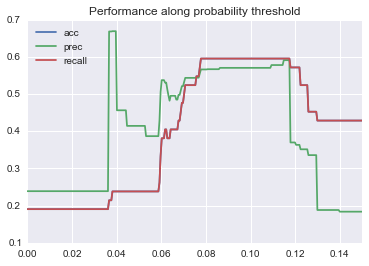

In [170]:
ax = accs.plot()
ax.set_title('Performance along probability threshold')

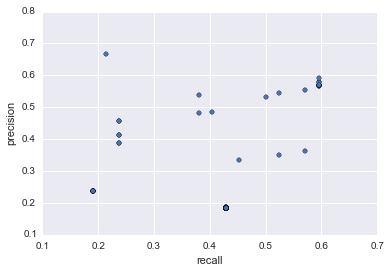

In [167]:
acsorted = accs.sort('recall', ascending=True)
ax = acsorted.plot(kind='scatter', x='recall', y='prec', legend=False)
ax.set_ylabel('precision')

In [173]:
best = prediction_probabilities.idxmax(1)
score = prediction_probabilities.std(1)
best[score<accs.acc.idxmax()] = 'Unknown'

In [177]:
best.unique(),test_labels_collected.unique()

(array(['Control', 'Effect_4', 'Unknown', 'Effect_1'], dtype=object),
 array(['Control', 'Effect_2', 'Unknown', 'Effect_1'], dtype=object))

In [184]:
print classification_report(test_labels_collected, best,)

             precision    recall  f1-score   support

    Control       0.60      1.00      0.75         6
   Effect_1       1.00      0.11      0.20         9
   Effect_2       0.00      0.00      0.00         9
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.62      1.00      0.77        18

avg / total       0.57      0.60      0.48        42



In [189]:
print "Best accuracy by choosing threshold = {:%}".format(accuracy_score(test_labels_collected, best))

Best accuracy by choosing threshold = 59.523810%
